Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alfa, beta, eps, v]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 37 seconds.


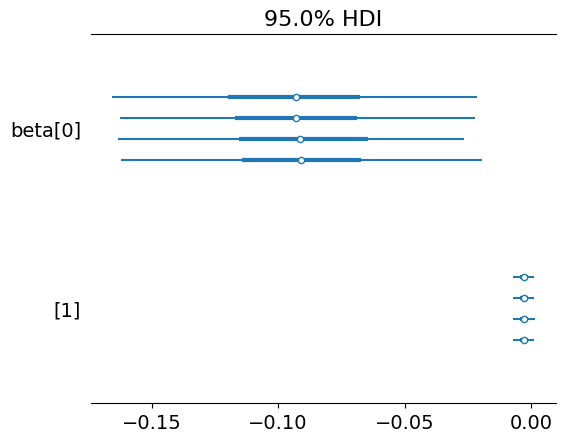

Sampling: [y_pred]


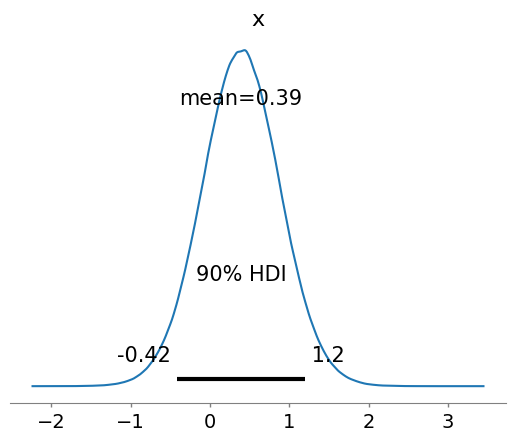

In [22]:
#Subiectul 1

import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

#a.
data = pd.read_csv('./Titanic.csv')
#Eliminam din date randurile care au valori cu 'nan' pentru varsta
data = data[data['Age'] >= 0]
x1 = data['Pclass'].values.astype(float)
x2 = data['Age'].values.astype(float)
X = np.column_stack((x1,x2))
y = data['Survived'].values

#b.
#Folosim distributia Student
with pm.Model() as model:
    alfa = pm.Normal('alfa', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=2)
    eps = pm.HalfCauchy('eps', 5)
    v = pm.Exponential('v', 1/30)
    X_shared = pm.MutableData('x_shared',X) 
    miu = pm.Deterministic('niu', alfa + pm.math.dot(X_shared, beta))
    y_pred = pm.StudentT('y_pred', mu=miu, sigma=eps, nu=v, observed=y)
    idata = pm.sample(2000, return_inferencedata=True)

#c.
#Estimari de 95% ale parametrilor beta
az.plot_forest(idata,hdi_prob=0.95,var_names=['beta'])
az.summary(idata,hdi_prob=0.95,var_names=['beta'])
plt.show()

''' 
    R: Din ce observam, variabila care influenteaza mai mult rezultatul este cea a clasei pasagerului. 
    In intervalul HDI al lui beta[1] apare 0, ceea ce inseamna ca varsta nu este un parametru bun.  
'''

#d.
#Actualizam valorile variabilei partajate
pm.set_data({"x_shared":[[2, 30]]}, model=model) 
#Generam predictii
ppc = pm.sample_posterior_predictive(idata, model=model)
#Distributia posterioara a datelor observate 
y_ppc = ppc.posterior_predictive['y_pred'].stack(sample=("chain", "draw")).values
az.plot_posterior(y_ppc,hdi_prob=0.9)
plt.show()

In [29]:
#Subiectul 2

import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import scipy.stats as stats

#a.
N = 10000
x = stats.geom.rvs(0.3, size=(2, N))
y = stats.geom.rvs(0.5, size=(2, N))
inside = x > y**2
outside = np.invert(inside)
